In [1]:
import tensorflow as tf
import numpy as np
import deepxde as dde

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
# Set the data type 
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

pi = tf.constant(np.pi,dtype=DTYPE)

def fun_u_0(x):
    return tf.sin( pi * x)

def fun_u_b(t,x):
    n = x.shape[0]
    return tf.zeros((n,1),dtype = DTYPE)

def f(x,t):
    return tf.constant(np.pi,dtype='float32')*tf.exp(-2*t)*tf.sin(np.pi*x)*tf.cos(np.pi*x)

def residual(u,u_t,u_x,u_xx, l1, x,t):
    
    f_val = f(x,t)
    f_u = u_t + u*u_x- l1*u_xx - f_val

    return f_u

class PhysicsInformedNN:
    def __init__(self, lb, ub, layers, u0, x0, X):

        self.lambda1 = 1/tf.constant(np.power(np.pi,2),dtype='float32')
        self.lb = lb
        self.ub = ub
                
        self.layers = layers

        self.u0 = u0
        self.X0 = x0

        self.X = X

        self.model = self.initialize_NN(layers)

    def initialize_NN(self,layers):
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(layers[0]))
        scaling_layer = tf.keras.layers.Lambda(
            lambda x: 2.0*(x-self.lb)/(self.ub-self.lb)-1.0)
        model.add(scaling_layer)
        num_layers = len(layers)
        for i in range(1,num_layers-2):
            model.add(tf.keras.layers.Dense(layers[i],
                                            activation=tf.keras.activations.get('tanh'),
                                            kernel_initializer='glorot_normal'))
        model.add(tf.keras.layers.Dense(layers[-1]))

        return model
    

    def loss(self, X, X0, u0):
        u_pred = self.model(X0)
        
        loss = tf.reduce_mean(tf.square(u0-u_pred))

        r1 = self.get_residual(X)

        phi_ru = tf.reduce_mean(tf.square(r1))

        loss += phi_ru

        return loss
    
    def get_residual(self,X):
        with tf.GradientTape(persistent=True) as tape:
            x = X[:,0:1]
            t = X[:,1:2]

            tape.watch(x)
            tape.watch(t)

            u = self.model(tf.stack([x[:,0],t[:,0]], axis=1))


            u_t = tape.gradient(u,t)
            u_x = tape.gradient(u,x)
            u_xx = tape.gradient(u_x,x)


        del tape
        
        l1 = self.lambda1
        f_u = residual(u,u_t,u_x,u_xx,l1, x, t)

        return f_u
    
    def loss_gradient(self,X,X0,u0, v0):

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.loss(self, X, X0, u0, v0)
            g = tape.gradient(loss, self.model.trainable_variables)

        del tape
        return loss, g

    
    
    def train(self):
        def time_step():
            loss = self.loss(self.X, self.X0, self.u0)
            return loss
        variables = self.model.trainable_variables
        cor=50
        tol=1.0  * np.finfo(float).eps
        iter=50000
        fun=50000
        ls=50
        dde.optimizers.config.set_LBFGS_options(maxcor=cor, ftol=tol,  maxiter=iter, maxfun=fun, maxls=ls)
        dde.optimizers.tfp_optimizer.lbfgs_minimize(variables, time_step)
    # def optimization_step(self, cor=50, tol=1.0  * np.finfo(float).eps,  iter=50000, fun=50000, ls=50):
    #     def time_step():
    #         loss = self.loss(self.X, self.X0, self.u0)
    #         return loss
    #     variables = self.model.trainable_variables
    #     dde.optimizers.config.set_LBFGS_options(maxcor=cor, ftol=tol,  maxiter=iter, maxfun=fun, maxls=ls)
    #     dde.optimizers.tfp_optimizer.lbfgs_minimize(variables, time_step)
    #     return loss


In [3]:
import scipy

In [4]:
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

N_0 = 50
N_b = 50
N_r = 10000

tmin = 0.
tmax = 2.
xmin = -1.
xmax = 1.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([x_0 , t_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([x_b, t_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([ x_r,t_r], axis=1)

# Collect boundary and inital data in lists
X_data = tf.concat([X_0, X_b],0)
u_data = tf.concat([u_0, u_b],0)


In [ ]:
model = PhysicsInformedNN(xmin, xmax, layers, u_data, X_data, X_r)

In [ ]:
def time_step():
        loss = model.loss(model.X, model.X0, model.u0)
        return loss

In [ ]:
variables = model.model.trainable_variables

In [ ]:
cor=50
tol=1.0  * np.finfo(float).eps
iter=50000
fun=50000
ls=50

In [ ]:
dde.optimizers.config.set_LBFGS_options(maxcor=cor, ftol=tol,  maxiter=iter, maxfun=fun, maxls=ls)

In [ ]:
dde.optimizers.tfp_optimizer.lbfgs_minimize(variables, time_step)

LBfgsOptimizerResults(converged=<tf.Tensor: shape=(), dtype=bool, numpy=False>, failed=<tf.Tensor: shape=(), dtype=bool, numpy=True>, num_iterations=<tf.Tensor: shape=(), dtype=int32, numpy=1380>, num_objective_evaluations=<tf.Tensor: shape=(), dtype=int32, numpy=3847>, position=<tf.Tensor: shape=(2601,), dtype=float32, numpy=
array([-0.00230803, -0.18567568,  0.46122003, ...,  1.046792  ,
        0.79334795, -0.00480581], dtype=float32)>, objective_value=<tf.Tensor: shape=(), dtype=float32, numpy=4.466042e-06>, objective_gradient=<tf.Tensor: shape=(2601,), dtype=float32, numpy=
array([-5.4301054e-06,  3.8415601e-07, -8.5459324e-06, ...,
        1.1628581e-06, -1.9726940e-08, -6.7380461e-07], dtype=float32)>, position_deltas=<tf.Tensor: shape=(50, 2601), dtype=float32, numpy=
array([[-1.09728426e-05,  1.33216381e-05, -2.01463699e-05, ...,
         7.15255737e-06,  2.63452530e-05, -3.34330834e-05],
       [ 3.47020105e-05,  6.88433647e-05,  1.86562538e-04, ...,
         1.46985054e-04, 

In [6]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
import random

In [7]:
x = X_r[:,0]
y = X_r[:,1]
z = model.model(model.X)

NameError: name 'model' is not defined

In [ ]:
import matplotlib.animation as animation

In [ ]:
tiempo = []
sol1 = []
sol2 = []

x1 = np.arange(xmin,xmax,0.01)
xn = tf.convert_to_tensor(np.transpose([np.ravel(x1)]))

for i in np.arange(tmin,tmax,0.01):
    t = np.ones(x1.shape)*i
    tn = tf.convert_to_tensor(np.transpose([np.ravel(t)]))
    X = tf.concat([xn,tn],1)
    z = model.model(X)
    z = z.numpy()
    z = z.reshape(x1.shape)
    z2 = np.sin(np.pi*x1)*np.exp(-t)

    tiempo.append(t)
    sol1.append(z)
    sol2.append(z2)



In [ ]:
x = np.arange(xmin,xmax,0.01)
t = np.arange(tmin,tmax,0.01)
x,t = np.meshgrid(x,t)

xn = tf.convert_to_tensor(np.transpose([np.ravel(x)]))
tn = tf.convert_to_tensor(np.transpose([np.ravel(t)]))
X = tf.concat([xn,tn],1)

In [ ]:
z = model.model(X)
z = z.numpy()
z = z.reshape(x.shape)

In [ ]:
z2 = np.sin(np.pi*x)*np.exp(-t)

In [ ]:
np.sqrt(np.sum(np.power(z2-z,2)))

0.09019941184828595

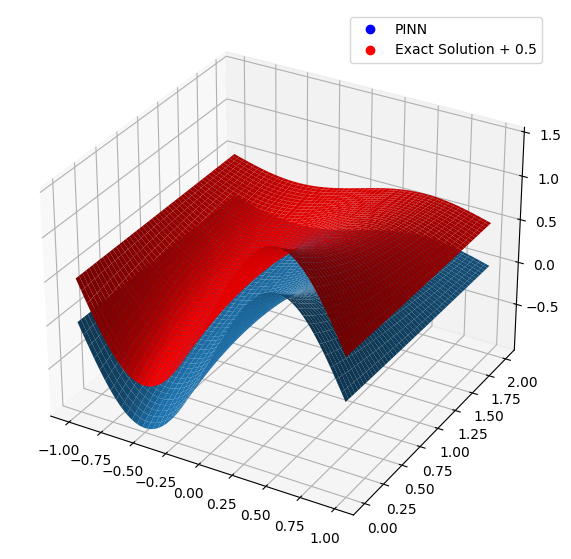

In [ ]:
import matplotlib as mpl

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.plot_surface(x, t, z)
ax.plot_surface(x, t, z2+0.5, color='r')



fake2Dline1 = mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
fake2Dline2 = mpl.lines.Line2D([0],[0], linestyle="none", c='r', marker = 'o')
ax.legend([fake2Dline1, fake2Dline2], ['PINN' , "Exact Solution + 0.5"], numpoints = 1)



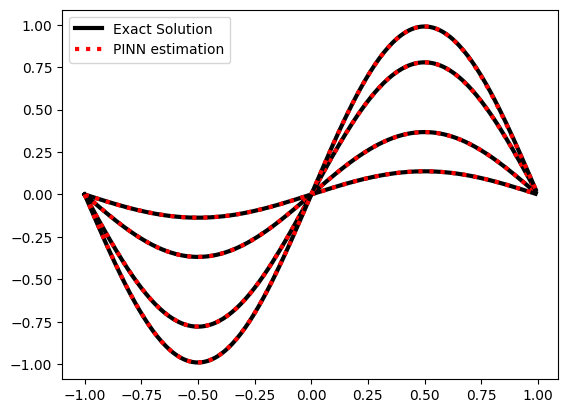

In [ ]:
fig, ax = plt.subplots()
l1 = ax.plot(x1,sol2[100], c="k", linewidth=3)
l2 = ax.plot(x1,sol1[100], c="r", linestyle='dotted', linewidth=3)
l3 = ax.plot(x1,sol2[25], c="k", linewidth=3)
l4 = ax.plot(x1,sol1[25], c="r", linestyle='dotted', linewidth=3)
l5 = ax.plot(x1,sol2[199], c="k", linewidth=3)
l6 = ax.plot(x1,sol1[199], c="r", linestyle='dotted', linewidth=3)
l7 = ax.plot(x1,sol2[1], c="k", linewidth=3)
l8 = ax.plot(x1,sol1[1], c="r", linestyle='dotted', linewidth=3)
plt.legend(["Exact Solution","PINN estimation"])
plt.show()

In [199]:
modelo11 = tf.saved_model.load("Burgers/PINN_Burgers_C1_L1_Export/")
modelo12 = tf.saved_model.load("Burgers/PINN_Burgers_C1_L2_Export/")
modelo13 = tf.saved_model.load("Burgers/PINN_Burgers_C1_L3_Export/")

modelo21 = tf.saved_model.load("Burgers/PINN_Burgers_C2_L1_Export/")
modelo22 = tf.saved_model.load("Burgers/PINN_Burgers_C2_L2_Export/")
modelo23 = tf.saved_model.load("Burgers/PINN_Burgers_C2_L3_Export/")

modelo31 = tf.saved_model.load("Burgers/PINN_Burgers_C3_L1_Export/")
modelo32 = tf.saved_model.load("Burgers/PINN_Burgers_C3_L2_Export/")
modelo33 = tf.saved_model.load("Burgers/PINN_Burgers_C3_L3_Export/")

In [129]:
def ECM (est, real):
    return np.mean(np.power(est-real,2))

def ErrorL2 (est, real):
    return np.sqrt(np.sum(np.power(est-real,2)))

In [ ]:
u1e = np.exp(-t) * np.sin(np.pi*x)
u2e = np.exp(t) * (x-np.power(x,2))
u3e = t* np.exp(x-np.power(x,2))

In [211]:
N_0 = 50
N_b = 50
N_r = 10000

tmin = 0.
tmax = 1.
xmin = 0.
xmax = 1.


# Lower bounds
lb = tf.constant([xmin, tmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([ xmax,tmax], dtype=DTYPE)

x = np.arange(xmin,xmax,0.01) 
xn = tf.convert_to_tensor(np.transpose([np.ravel(x)]), dtype = DTYPE)


uError = []
uMSE = [] 

pError = []
pMSE = [] 

for tv in range(0,11):
    tv = 0.1*tv
    print(tv)
   
    t = np.ones(x.shape) * tv
    tn = tf.convert_to_tensor(np.transpose([np.ravel(t)]), dtype = DTYPE)
    X = tf.concat([xn, tn],1)
    ue = t* np.exp(x-np.power(x,2))

    u1 = modelo31.serve(X)
    u2 = modelo32.serve(X)
    u3 = modelo33.serve(X)



    u1 = u1.numpy()
    u2 = u2.numpy()
    u3 = u3.numpy()


    u1 = u1.reshape(x.shape)
    u2 = u2.reshape(x.shape)
    u3 = u3.reshape(x.shape)


    e1u = ErrorL2(u1,ue)
    m1u = ECM(u1,ue)


    e2u = ErrorL2(u2,ue)
    m2u = ECM(u2,ue)


    e3u = ErrorL2(u3,ue)
    m3u = ECM(u3,ue)


    uError.append([e1u,e2u,e3u])
    uMSE.append([m1u,m2u,m3u]) 


0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0


In [202]:
tlist =  [0.1*i for i in range(0,11)]

In [212]:
for j in range(0,3):
    print("Caso ",j)
    for i in range(len(uError)):
        print("%.1f & $ %1.4e$ & $ %1.4e $ \\\\" % (tlist[i],uMSE[i][j],uError[i][j]))

Caso  0
0.0 & $ 5.6127e-03$ & $ 7.4918e-01 $ \\
0.1 & $ 1.2901e-02$ & $ 1.1358e+00 $ \\
0.2 & $ 3.9804e-02$ & $ 1.9951e+00 $ \\
0.3 & $ 8.6364e-02$ & $ 2.9388e+00 $ \\
0.4 & $ 1.5251e-01$ & $ 3.9053e+00 $ \\
0.5 & $ 2.3810e-01$ & $ 4.8796e+00 $ \\
0.6 & $ 3.4299e-01$ & $ 5.8565e+00 $ \\
0.7 & $ 4.6711e-01$ & $ 6.8345e+00 $ \\
0.8 & $ 6.1058e-01$ & $ 7.8140e+00 $ \\
0.9 & $ 7.7382e-01$ & $ 8.7967e+00 $ \\
1.0 & $ 9.5760e-01$ & $ 9.7857e+00 $ \\
Caso  1
0.0 & $ 1.9697e-01$ & $ 4.4381e+00 $ \\
0.1 & $ 1.2659e-01$ & $ 3.5579e+00 $ \\
0.2 & $ 7.2791e-02$ & $ 2.6980e+00 $ \\
0.3 & $ 3.4688e-02$ & $ 1.8625e+00 $ \\
0.4 & $ 1.1345e-02$ & $ 1.0651e+00 $ \\
0.5 & $ 1.8778e-03$ & $ 4.3333e-01 $ \\
0.6 & $ 5.5493e-03$ & $ 7.4494e-01 $ \\
0.7 & $ 2.1862e-02$ & $ 1.4786e+00 $ \\
0.8 & $ 5.0643e-02$ & $ 2.2504e+00 $ \\
0.9 & $ 9.2116e-02$ & $ 3.0351e+00 $ \\
1.0 & $ 1.4694e-01$ & $ 3.8332e+00 $ \\
Caso  2
0.0 & $ 3.9095e-09$ & $ 6.2526e-04 $ \\
0.1 & $ 4.0976e-09$ & $ 6.4012e-04 $ \\
0.2 & $ 1.2145e-

In [124]:
DTYPE = 'float32'

tmin = 0.
tmax = 1.
xmin = 0.
xmax = 1.

x = np.arange(xmin,xmax,0.001)
t = np.arange(tmin,tmax,0.001)
x,t = np.meshgrid(x,t)

xn = tf.convert_to_tensor(np.transpose([np.ravel(x)]), dtype=DTYPE)
tn = tf.convert_to_tensor(np.transpose([np.ravel(t)]), dtype=DTYPE)
X = tf.concat([xn,tn],1)

In [125]:
u11 = modelo11.serve(X)
u12 = modelo12.serve(X)
u13 = modelo13.serve(X)

u21 = modelo21.serve(X)
u22 = modelo22.serve(X)
u23 = modelo23.serve(X)

u31 = modelo31.serve(X)
u32 = modelo32.serve(X)
u33 = modelo33.serve(X)

In [126]:
u11 = u11.numpy()
u12 = u12.numpy()
u13 = u13.numpy()

u21 = u21.numpy()
u22 = u22.numpy()
u23 = u23.numpy()

u31 = u31.numpy()
u32 = u32.numpy()
u33 = u33.numpy()

In [127]:
u11 = u11.reshape(x.shape)
u12 = u12.reshape(x.shape)
u13 = u13.reshape(x.shape)

u21 = u21.reshape(x.shape)
u22 = u22.reshape(x.shape)
u23 = u23.reshape(x.shape)

u31 = u31.reshape(x.shape)
u32 = u32.reshape(x.shape)
u33 = u33.reshape(x.shape)

In [128]:
u1e = np.exp(-t) * np.sin(np.pi*x)
u2e = np.exp(t) * (x-np.power(x,2))
u3e = t* np.exp(x-np.power(x,2))

In [136]:
e11 = ErrorL2(u11,u1e)
e12 = ErrorL2(u12,u1e)
e13 = ErrorL2(u13,u1e)

e21 = ErrorL2(u21,u2e)
e22 = ErrorL2(u22,u2e)
e23 = ErrorL2(u23,u2e)

e31 = ErrorL2(u31,u3e)
e32 = ErrorL2(u32,u3e)
e33 = ECM(u33,u3e)

print("Error C1 A1:",e11)
print("Error C1 A2:",e12)
print("Error C1 A3:",e13)

print("Error C2 A1:",e21)
print("Error C2 A2:",e22)
print("Error C2 A3:",e23)

print("Error C3 A1:",e31)
print("Error C3 A2:",e32)
print("Error C3 A3:",e33)




Error C1 A1: 0.08439809523181947
Error C1 A2: 0.08913786221459429
Error C1 A3: 0.05362559681079342
Error C2 A1: 0.09566126525391111
Error C2 A2: 0.23546317044848922
Error C2 A3: 0.264660057445845
Error C3 A1: 564.7619173927299
Error C3 A2: 240.77712509674203
Error C3 A3: 9.354617062020903e-09


ValueError: Argument Z must be 2-dimensional.

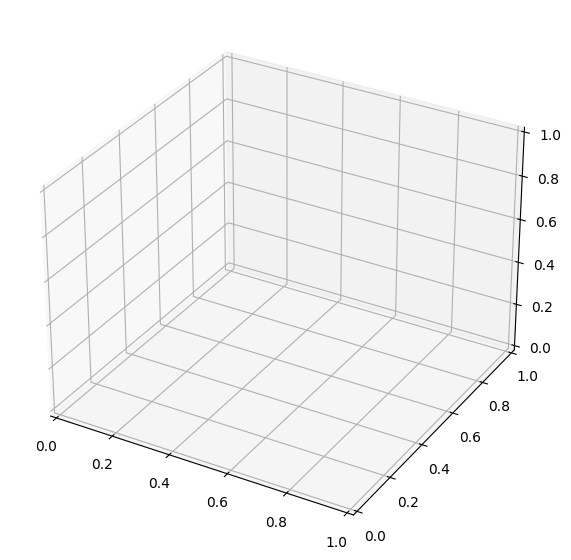

In [213]:
import matplotlib as mpl
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
import random

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.plot_surface(x, t, u31)
ax.plot_surface(x, t, u2e)


fake2Dline1 = mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
fake2Dline2 = mpl.lines.Line2D([0],[0], linestyle="none", c='r', marker = 'o')
ax.legend([fake2Dline1, fake2Dline2], ['PINN' , "Exact Solution + 0.5"], numpoints = 1)

In [185]:
modelo11 = tf.saved_model.load("NavierStokes/PINN_Burgers_C1_L1_Export/")
modelo12 = tf.saved_model.load("NavierStokes/PINN_Burgers_C1_L2_Export/")
modelo13 = tf.saved_model.load("NavierStokes/PINN_Burgers_C1_L3_Export/")
modelo14 = tf.saved_model.load("NavierStokes/PINN_Burgers_C1_L4_Export/")

modelo22 = tf.saved_model.load("NavierStokes/PINN_Burgers_C2_L2_Export/")
modelo23 = tf.saved_model.load("NavierStokes/PINN_Burgers_C2_L3_Export/")
modelo21 = tf.saved_model.load("NavierStokes/PINN_Burgers_C2_L1_Export/")
modelo24 = tf.saved_model.load("NavierStokes/PINN_Burgers_C2_L4_Export/")

In [197]:
N_0 = 50
N_b = 50
N_r = 10000

tmin = 0.
tmax = 1.
xmin = 0.
xmax = 1.


# Lower bounds
lb = tf.constant([xmin, tmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([ xmax,tmax], dtype=DTYPE)

x = np.arange(xmin,xmax,0.01) 
xn = tf.convert_to_tensor(np.transpose([np.ravel(x)]), dtype = DTYPE)




pe = -np.sin(np.pi*x)

uError = []
uMSE = [] 

pError = []
pMSE = [] 

for tv in range(0,11):
    tv = 0.1*tv
    print(tv)
   
    t = np.ones(x.shape) * tv
    tn = tf.convert_to_tensor(np.transpose([np.ravel(t)]), dtype = DTYPE)
    X = tf.concat([xn, tn],1)
    ue =np.exp(t) * (x-np.power(x,2))
    up1 = modelo21.serve(X)
    up2 = modelo22.serve(X)
    up3 = modelo23.serve(X)
    # up4 = modelo4.serve(X)
    up5 = modelo24.serve(X)

    u1 = up1[:,0:1]
    u2 = up2[:,0:1]
    u3 = up3[:,0:1]
    # u4 = up4[:,0:1]
    u5 = up5[:,0:1]

    u1 = u1.numpy()
    u2 = u2.numpy()
    u3 = u3.numpy()
    # u4 = u4.numpy()
    u5 = u5.numpy()

    u1 = u1.reshape(x.shape)
    u2 = u2.reshape(x.shape)
    u3 = u3.reshape(x.shape)
    # u4 = u4.reshape(x.shape)
    u5 = u5.reshape(x.shape)

    p1 = up1[:,1:2]
    p2 = up2[:,1:2]
    p3 = up3[:,1:2]
    # p4 = up4[:,1:2]
    p5 = up5[:,1:2]

    p1 = p1.numpy()
    p2 = p2.numpy()
    p3 = p3.numpy()
    # p4 = p4.numpy()
    p5 = p5.numpy()

    p1 = p1.reshape(x.shape)
    p2 = p2.reshape(x.shape)
    p3 = p3.reshape(x.shape)
    # p4 = p4.reshape(x.shape)
    p5 = p5.reshape(x.shape)

    e1u = ErrorL2(u1,ue)
    m1u = ECM(u1,ue)
    e1p = ErrorL2(p1,pe)
    m1p = ECM(p1,pe)

    e2u = ErrorL2(u2,ue)
    m2u = ECM(u2,ue)
    e2p = ErrorL2(p2,pe)
    m2p = ECM(p2,pe)

    e3u = ErrorL2(u3,ue)
    m3u = ECM(u3,ue)
    e3p = ErrorL2(p3,pe)
    m3p = ECM(p3,pe)

    e5u = ErrorL2(u5,ue)
    m5u = ECM(u5,ue)
    e5p = ErrorL2(p5,pe)
    m5p = ECM(p5,pe)

    uError.append([e1u,e2u,e3u,e5u])
    uMSE.append([m1u,m2u,m3u,m5u]) 

    pError.append([e1p,e2p,e3p,e5p])
    pMSE.append([m1p,m2p,m3p,m5p]) 

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0


In [188]:
tlist =  [0.1*i for i in range(0,11)]

In [198]:
for j in range(0,4):
    print("Caso ",j)
    for i in range(len(pError)):
        print("%.1f & $ %1.4e$ & $ %.4f $ & $ %1.4e $ & $ %.4f$ \\\\" % (tlist[i],uMSE[i][j],uError[i][j],pMSE[i][j],pError[i][j]))

Caso  0
0.0 & $ 2.3421e-01$ & $ 4.8395 $ & $ 1.0760e+00 $ & $ 10.3730$ \\
0.1 & $ 1.7688e-01$ & $ 4.2057 $ & $ 9.8685e-01 $ & $ 9.9340$ \\
0.2 & $ 1.3509e-01$ & $ 3.6755 $ & $ 9.1463e-01 $ & $ 9.5636$ \\
0.3 & $ 1.0614e-01$ & $ 3.2579 $ & $ 8.5741e-01 $ & $ 9.2596$ \\
0.4 & $ 8.7552e-02$ & $ 2.9589 $ & $ 8.1312e-01 $ & $ 9.0173$ \\
0.5 & $ 7.7282e-02$ & $ 2.7800 $ & $ 7.7976e-01 $ & $ 8.8304$ \\
0.6 & $ 7.3767e-02$ & $ 2.7160 $ & $ 7.5539e-01 $ & $ 8.6913$ \\
0.7 & $ 7.5994e-02$ & $ 2.7567 $ & $ 7.3823e-01 $ & $ 8.5920$ \\
0.8 & $ 8.3508e-02$ & $ 2.8898 $ & $ 7.2660e-01 $ & $ 8.5241$ \\
0.9 & $ 9.6403e-02$ & $ 3.1049 $ & $ 7.1895e-01 $ & $ 8.4791$ \\
1.0 & $ 1.1530e-01$ & $ 3.3955 $ & $ 7.1382e-01 $ & $ 8.4488$ \\
Caso  1
0.0 & $ 8.6068e-07$ & $ 0.0093 $ & $ 2.8796e-03 $ & $ 0.5366$ \\
0.1 & $ 2.4480e-06$ & $ 0.0156 $ & $ 3.2165e-03 $ & $ 0.5671$ \\
0.2 & $ 3.6892e-06$ & $ 0.0192 $ & $ 3.7059e-03 $ & $ 0.6088$ \\
0.3 & $ 4.4041e-06$ & $ 0.0210 $ & $ 4.3900e-03 $ & $ 0.6626$ \\
0.4 & $ 

In [138]:
up11 = modelo11.serve(X)
up12 = modelo12.serve(X)
up13 = modelo13.serve(X)
up14 = modelo14.serve(X)

up21 = modelo21.serve(X)
up22 = modelo22.serve(X)
up23 = modelo23.serve(X)
up24 = modelo24.serve(X)


In [139]:
u11 = up11[:,0:1]
u12 = up12[:,0:1]
u13 = up13[:,0:1]
u14 = up14[:,0:1]

u21 = up21[:,0:1]
u22 = up22[:,0:1]
u23 = up23[:,0:1]
u24 = up24[:,0:1]

In [140]:
u11 = u11.numpy()
u12 = u12.numpy()
u13 = u13.numpy()
u14 = u14.numpy()

u21 = u21.numpy()
u22 = u22.numpy()
u23 = u23.numpy()
u24 = u24.numpy()



In [141]:
u11 = u11.reshape(x.shape)
u12 = u12.reshape(x.shape)
u13 = u13.reshape(x.shape)
u14 = u14.reshape(x.shape)

u21 = u21.reshape(x.shape)
u22 = u22.reshape(x.shape)
u23 = u23.reshape(x.shape)
u24 = u24.reshape(x.shape)

In [142]:
p11 = up11[:,1:2]
p12 = up12[:,1:2]
p13 = up13[:,1:2]
p14 = up14[:,1:2]

p21 = up21[:,1:2]
p22 = up22[:,1:2]
p23 = up23[:,1:2]
p24 = up24[:,1:2]

In [143]:
p11 = p11.numpy()
p12 = p12.numpy()
p13 = p13.numpy()
p14 = p14.numpy()

p21 = p21.numpy()
p22 = p22.numpy()
p23 = p23.numpy()
p24 = p24.numpy()

In [144]:
p11 = p11.reshape(x.shape)
p12 = p12.reshape(x.shape)
p13 = p13.reshape(x.shape)
p14 = p14.reshape(x.shape)

p21 = p21.reshape(x.shape)
p22 = p22.reshape(x.shape)
p23 = p23.reshape(x.shape)
p24 = p24.reshape(x.shape)

In [145]:
u1e = np.exp(-t) * np.sin(np.pi*x)
u2e = np.exp(t) * (x-np.power(x,2))

pe = -np.sin(np.pi*x)

In [149]:
ECM11 = ECM(p11,pe)
ECM12 = ECM(p12,pe)
ECM13 = ECM(p13,pe)
ECM14 = ECM(p14,pe)

ECM21 = ECM(u21,u2e)
ECM22 = ECM(u22,u2e)
ECM23 = ECM(u23,u2e)
ECM24 = ECM(u24,u2e)

L2_11 = ErrorL2(p11,pe)
L2_12 = ErrorL2(p12,pe)
L2_13 = ErrorL2(p13,pe)
L2_14 = ErrorL2(p14,pe)

L2_21 = ErrorL2(u21,u2e)
L2_22 = ErrorL2(u22,u2e)
L2_23 = ErrorL2(u23,u2e)
L2_24 = ErrorL2(u24,u2e)

print("ECM C1 A1:",ECM11)
print("ECM C1 A2:",ECM12)
print("ECM C1 A3:",ECM13)
print("ECM C1 A4:",ECM14)

print("Error L2 C1 A1:",L2_11)
print("Error L2 C1 A2:",L2_12)
print("Error L2 C1 A3:",L2_13)
print("Error L2 C1 A4:",L2_14)

print("ECM C2 A1:",ECM21)
print("ECM C2 A2:",ECM22)
print("ECM C2 A3:",ECM23)
print("ECM C2 A4:",ECM24)

print("Error L2 C2 A1:",L2_21)
print("Error L2 C2 A2:",L2_22)
print("Error L2 C2 A3:",L2_23)
print("Error L2 C2 A4:",L2_24)



ECM C1 A1: 3.891426890064389e-05
ECM C1 A2: 1.4196103116435872e-05
ECM C1 A3: 0.0006304321404549165
ECM C1 A4: 1.3933815986528326e-05
Error L2 C1 A1: 6.238130240756751
Error L2 C1 A2: 3.7677716380422885
Error L2 C1 A3: 25.108407764231416
Error L2 C1 A4: 3.732802698580294
ECM C2 A1: 0.10829305085213067
ECM C2 A2: 1.2632439797709929e-05
ECM C2 A3: 0.0017306006351200654
ECM C2 A4: 0.002229884463200152
Error L2 C2 A1: 329.0790951308373
Error L2 C2 A2: 3.554214371378002
Error L2 C2 A3: 41.6004884000184
Error L2 C2 A4: 47.22165248273457


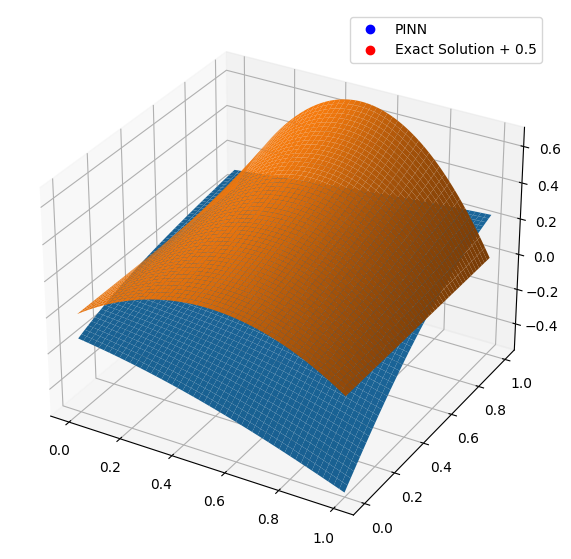

In [119]:
import matplotlib as mpl
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
import random

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.plot_surface(x, t, u21)
ax.plot_surface(x, t, u2e )


fake2Dline1 = mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
fake2Dline2 = mpl.lines.Line2D([0],[0], linestyle="none", c='r', marker = 'o')
ax.legend([fake2Dline1, fake2Dline2], ['PINN' , "Exact Solution + 0.5"], numpoints = 1)

In [151]:
modelo1 = tf.saved_model.load("NavierStokes2D/PINN_Burgers_C1_L1_Export/")
modelo2 = tf.saved_model.load("NavierStokes2D/PINN_Burgers_C1_L2_Export/")
modelo3 = tf.saved_model.load("NavierStokes2D/PINN_Burgers_C1_L3_Export/")
# modelo4 = tf.saved_model.load("NavierStokes2D/PINN_Burgers_C1_L4_Export/")
modelo5 = tf.saved_model.load("NavierStokes2D/PINN_Burgers_C1_L5_Export/")

In [163]:
N_0 = 50
N_b = 50
N_r = 10000

tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.
ymin = -1.
ymax = 1.

# Lower bounds
lb = tf.constant([xmin, ymin, tmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([ xmax, ymax,tmax], dtype=DTYPE)

x = np.arange(xmin,xmax,0.01)
y = np.arange(ymin,ymax,0.01)
x,y = np.meshgrid(x,y)


pe = x*y

uError = []
uMSE = [] 

pError = []
pMSE = [] 

for tv in range(0,11):
    tv = 0.1*tv
    print(tv)
    xn = tf.convert_to_tensor(np.transpose([np.ravel(x)]), dtype = DTYPE)
    yn = tf.convert_to_tensor(np.transpose([np.ravel(y)]), dtype = DTYPE)
    t = np.ones(x.shape) * tv
    tn = tf.convert_to_tensor(np.transpose([np.ravel(t)]), dtype = DTYPE)
    X = tf.concat([xn,yn, tn],1)
    ue = np.exp(-t) * (1-np.power(x,2)*np.power(y,2))
    up1 = modelo1.serve(X)
    up2 = modelo2.serve(X)
    up3 = modelo3.serve(X)
    # up4 = modelo4.serve(X)
    up5 = modelo5.serve(X)

    u1 = up1[:,0:1]
    u2 = up2[:,0:1]
    u3 = up3[:,0:1]
    # u4 = up4[:,0:1]
    u5 = up5[:,0:1]

    u1 = u1.numpy()
    u2 = u2.numpy()
    u3 = u3.numpy()
    # u4 = u4.numpy()
    u5 = u5.numpy()

    u1 = u1.reshape(x.shape)
    u2 = u2.reshape(x.shape)
    u3 = u3.reshape(x.shape)
    # u4 = u4.reshape(x.shape)
    u5 = u5.reshape(x.shape)

    p1 = up1[:,1:2]
    p2 = up2[:,1:2]
    p3 = up3[:,1:2]
    # p4 = up4[:,1:2]
    p5 = up5[:,1:2]

    p1 = p1.numpy()
    p2 = p2.numpy()
    p3 = p3.numpy()
    # p4 = p4.numpy()
    p5 = p5.numpy()

    p1 = p1.reshape(x.shape)
    p2 = p2.reshape(x.shape)
    p3 = p3.reshape(x.shape)
    # p4 = p4.reshape(x.shape)
    p5 = p5.reshape(x.shape)

    e1u = ErrorL2(u1,ue)
    m1u = ECM(u1,ue)
    e1p = ErrorL2(p1,pe)
    m1p = ECM(p1,pe)

    e2u = ErrorL2(u2,ue)
    m2u = ECM(u2,ue)
    e2p = ErrorL2(p2,pe)
    m2p = ECM(p2,pe)

    e3u = ErrorL2(u3,ue)
    m3u = ECM(u3,ue)
    e3p = ErrorL2(p3,pe)
    m3p = ECM(p3,pe)

    e5u = ErrorL2(u5,ue)
    m5u = ECM(u5,ue)
    e5p = ErrorL2(p5,pe)
    m5p = ECM(p5,pe)

    uError.append([e1u,e2u,e3u,e5u])
    uMSE.append([m1u,m2u,m3u,m5u]) 

    pError.append([e1p,e2p,e3p,e5p])
    pMSE.append([m1p,m2p,m3p,m5p]) 




0.0


0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0


In [177]:
tv = [0.1*i for i in range(0,11)]

In [184]:
for i in range(len(pError)):
    print("%.1f & $ %1.4e$ & $ %.4f $ & $ %1.4e $ & $ %.4f$ \\\\" % (tv[i],uMSE[i][3],uError[i][3],pMSE[i][3],pError[i][3]))

0.0 & $ 1.6969e-05$ & $ 0.8239 $ & $ 1.9618e-02 $ & $ 28.0128$ \\
0.1 & $ 9.4158e-04$ & $ 6.1370 $ & $ 9.3919e-03 $ & $ 19.3824$ \\
0.2 & $ 3.1448e-03$ & $ 11.2157 $ & $ 8.0040e-03 $ & $ 17.8930$ \\
0.3 & $ 5.9426e-03$ & $ 15.4176 $ & $ 1.0275e-02 $ & $ 20.2732$ \\
0.4 & $ 8.9039e-03$ & $ 18.8721 $ & $ 1.4243e-02 $ & $ 23.8686$ \\
0.5 & $ 1.1787e-02$ & $ 21.7140 $ & $ 1.9205e-02 $ & $ 27.7166$ \\
0.6 & $ 1.4485e-02$ & $ 24.0708 $ & $ 2.4883e-02 $ & $ 31.5488$ \\
0.7 & $ 1.6976e-02$ & $ 26.0586 $ & $ 3.1112e-02 $ & $ 35.2773$ \\
0.8 & $ 1.9294e-02$ & $ 27.7807 $ & $ 3.7755e-02 $ & $ 38.8615$ \\
0.9 & $ 2.1502e-02$ & $ 29.3270 $ & $ 4.4696e-02 $ & $ 42.2827$ \\
1.0 & $ 2.3676e-02$ & $ 30.7742 $ & $ 5.1843e-02 $ & $ 45.5382$ \\


In [87]:
up1 = modelo1.serve(X)
up2 = modelo2.serve(X)
up3 = modelo3.serve(X)
up4 = modelo4.serve(X)
up5 = modelo5.serve(X)

In [88]:
u1 = up1[:,0:1]
u2 = up2[:,0:1]
u3 = up3[:,0:1]
u4 = up4[:,0:1]
u5 = up5[:,0:1]


In [89]:
u1 = u1.numpy()
u2 = u2.numpy()
u3 = u3.numpy()
u4 = u4.numpy()
u5 = u5.numpy()

In [90]:
u1 = u1.reshape(x.shape)
u2 = u2.reshape(x.shape)
u3 = u3.reshape(x.shape)
u4 = u4.reshape(x.shape)
u5 = u5.reshape(x.shape)

In [91]:
p1 = up1[:,1:2]
p2 = up2[:,1:2]
p3 = up3[:,1:2]
p4 = up4[:,1:2]
p5 = up5[:,1:2]


In [92]:
p1 = p1.numpy()
p2 = p2.numpy()
p3 = p3.numpy()
p4 = p4.numpy()
p5 = p5.numpy()

In [93]:
p1 = p1.reshape(x.shape)
p2 = p2.reshape(x.shape)
p3 = p3.reshape(x.shape)
p4 = p4.reshape(x.shape)
p5 = p5.reshape(x.shape)

In [97]:
ue = np.exp(-t) * (1-np.power(x,2)*np.power(y,2))
pe = x*y

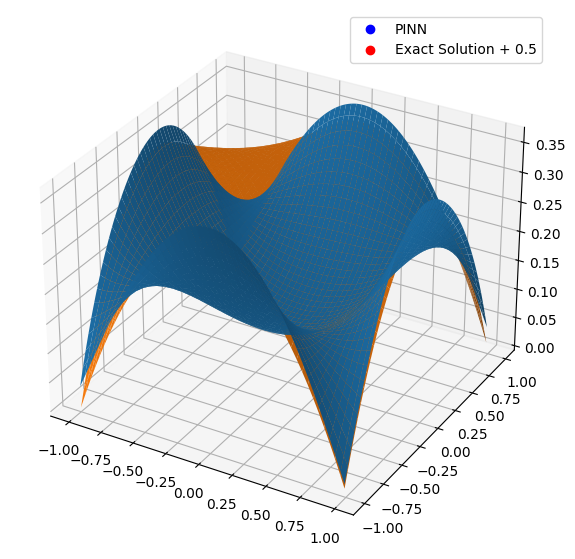

In [162]:
import matplotlib as mpl
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
import random

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.plot_surface(x, y, u5)
ax.plot_surface(x, y, ue )


fake2Dline1 = mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
fake2Dline2 = mpl.lines.Line2D([0],[0], linestyle="none", c='r', marker = 'o')
ax.legend([fake2Dline1, fake2Dline2], ['PINN' , "Exact Solution + 0.5"], numpoints = 1)